# GAN (Generative Adversarial Network)
## Генеративно-состязательная нейросеть

Сегодня мы поговорим о генеративно-состязательных нейросетях. Они же:
* генеративные соревновательные сети
* порождающие соперничающие сети
* порождающие соревнующиеся сети

#### Примеры работы GAN:
* https://www.thispersondoesnotexist.com/ - генерация несуществующих лиц
* https://thiscatdoesnotexist.com/ - генерация несуществующих котов (ошибки в генерации котов: https://aiweirdness.com/post/182633984547/gancats)
* https://www.youtube.com/watch?v=PCBTZh41Ris - генерация танцевальных движений


#### Генеративно-состязательная сеть (англ. Generative adversarial network)
— алгоритм машинного обучения без учителя, построенный на комбинации из двух нейронных сетей, одна из которых (сеть $G$, генератор) генерирует образцы，а другая (сеть $D$, дискриминатор) старается отличить правильные («подлинные») образцы от неправильных. https://ru.wikipedia.org/wiki/%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%BE-%D1%81%D0%BE%D1%81%D1%82%D1%8F%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D1%82%D1%8C

Если совсем коротко, то:

$$\min _{G} \max _{D} V(D, G)=\mathbb{E}_{\boldsymbol{x} \sim p_{\text {data }}(\boldsymbol{x})}[\log D(\boldsymbol{x})]+\mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})}[\log (1-D(G(\boldsymbol{z})))]$$

Где: 
* $x$ - реальные данные из обучающй выборки
* $D(x)$ - результат работы дискриминатора, т.е. вероятность того, что перед нами несгенерированные данные
* $z$ - случайный вектор фиксированной длины, выбранный из нормального распределения
* $G(z)$ - сгенерированные из $z$ данные

Задача для $G$ - генерировать данные $p_g$ с таким же распределением как и у реальных данных  $p_{data}$ .
Цель $D$ же - отличать сгенерированные данные от оригиналов. 
Тогда $D(G(z))$ - вероятность того, что данные из генератора являются реальными. Идеальный результат обучения GAN - $p_{data} = p_g$

### Дискриминатор ($D$)

Модель дискриминатора берет входные данные (реальные или сгенерированный) и предсказывает к какому из этих двух классов принадлежат эти данные.
Обучение сводится к минимизация функции потерь.

После процесса обучения модель дискриминатора отбрасывается, поскольку нас уже интересует только генерация данных.

### Генератор ($G$)

Задача генератора - создавать «поддельные» изображения, похожие на те, что в обучающей выборке. 
Во время обучения генератор постоянно пытается обыграть дискриминатор, улучшая качество подделок.


### Vanilla GAN

Рассмотрим реализацю самой первой статьи по GAN'ам на классическом датасете MNIST 

Generative Adversarial Nets Ian J. Goodfellow (2014) https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf  

![GANs_%D1%81%D1%85%D0%B5%D0%BC%D0%B0.png](attachment:GANs_%D1%81%D1%85%D0%B5%D0%BC%D0%B0.png)

Подключаем нужные модули и библиотеки

In [ ]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и сохранение ################################
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [ ]:
%%time

UsageError: %%time is a cell magic, but the cell body is empty. Did you mean the line magic %time (single %)?


In [ ]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
######## функция для вывода и сохранения изображения ########
def sample_image(static_sample, save_img = False):
    npimg = make_grid(static_sample.data[:25]).cpu().numpy()
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    if save_img:
        save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

Параметры для обучения обеих моделей

In [ ]:
n_epochs = 200
batch_size = 64
lr = 0.0002

b1 = 0.5
b2 = 0.999

latent_dim = 100

n_classes = 10
img_size = 28
channels = 1

sample_interval = 25

img_shape = (channels, img_size, img_size)

Генератор

##### Способы организации слоев в генераторе

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat, normalize=True,): #activation='relu'
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
#             layers.append(self.activations[activation])
            
            return layers

        self.activations = {'lrelu': nn.LeakyReLU(0.2, inplace=True),
                 'relu': nn.ReLU(0.2)}
        
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
        

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


Мы можем:
* Делать блоки из слоев с нужными параметрами для повторяющихся кусков
* Использовать словарь со слоями для использования различных слоев при условиях задачи

#### ... Небольшое отступление 
Создание своих слоев

In [ ]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) 

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

#### nn.init
https://pytorch.org/docs/stable/nn.init.html

Дискриминатор 

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

Загрузка датасета

In [ ]:
real_data = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

Extracting ../../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw


Extracting ../../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw


Extracting ../../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw




Extracting ../../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


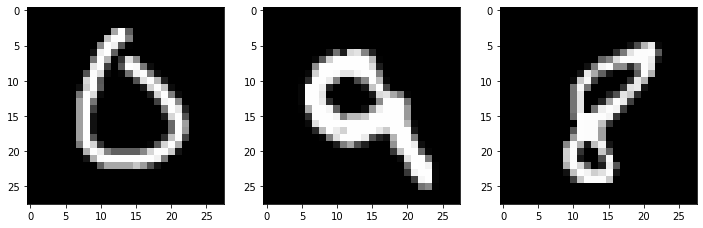

In [ ]:
dataiter = iter(real_data)
images, labels = dataiter.next()
images = images.numpy()

img = np.squeeze(images[0])
img1 = np.squeeze(images[1])
img2 = np.squeeze(images[2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))
ax1.imshow(img, cmap='gray')
ax2.imshow(img1, cmap='gray')
ax3.imshow(img2, cmap='gray')

Инициализация

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

In [ ]:
d_loss_history = []
g_loss_history = []

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 199/200] [Batch 913/938] [D loss: 0.302197] [G loss: 2.315650]


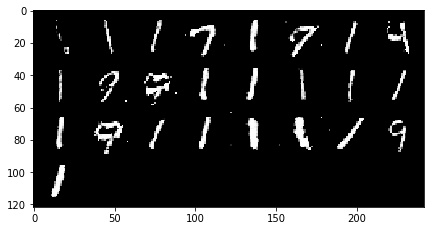

<Figure size 432x288 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

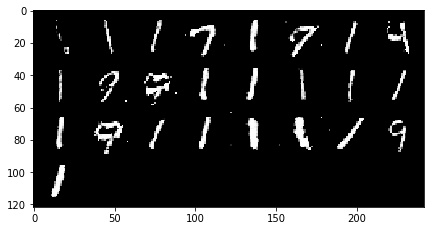

In [ ]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')



for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(real_data):

        batch_size = imgs.shape[0]
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_imgs = Variable(imgs.type(torch.FloatTensor)).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)

        gen_imgs = generator(z)

        validity = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_imgs.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            plt.clf()
            
            display.clear_output(wait=False)
            sample_image(gen_imgs)
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 

            
            display.display(plt.gcf())

#             d_loss_history.append(d_loss)
#             g_loss_history.append(g_loss)

#             plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
#             plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
#             plt.legend(handles=[red_patch, green_patch])
#             plt.show()

            

Анимация первых 88 эпох обучения

![myimage.gif](attachment:myimage.gif)

In [ ]:
torch.save(generator.state_dict(), "vanilla_gan.pth")

https://medium.com/@jonathan_hui

Домашнее задание: 

1. Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции $y = \frac{sin(x)}{x} - \frac{x}{10}$. При выполненинии данного задания структура GAN остается той же, но Вам нужно:
 * Сгенерировать настоящие данные
 * Изменить архитектуру дискриминатора и генератора
 * Без графиков домашку не принимаю (реальные данные + результат модели, графики двух лоссов)
 * Дополнительно: посмотреть зависимость от количества изначальных реальных данных (график) 
 

2. Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.




In [1]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и сохранение ################################
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure

In [2]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Func_y: [ 0.30821515  0.30568473  0.30318078  0.30070362  0.29825357  0.29583096
  0.29343611  0.29106934  0.28873096  0.28642128  0.28414062  0.28188929
  0.27966758  0.2774758   0.27531426  0.27318324  0.27108305  0.26901398
  0.26697631  0.26497034  0.26299634  0.26105459  0.25914538  0.25726897
  0.25542564  0.25361565  0.25183928  0.25009678  0.2483884   0.24671442
  0.24507506  0.2434706   0.24190126  0.24036729  0.23886893  0.23740641
  0.23597996  0.23458981  0.23323619  0.2319193   0.23063937  0.22939661
  0.22819123  0.22702343  0.22589341  0.22480136  0.22374749  0.22273197
  0.221755    0.22081675  0.2199174   0.21905711  0.21823607  0.21745443
  0.21671235  0.21600999  0.21534749  0.21472501  0.21414268  0.21360064
  0.21309904  0.21263799  0.21221761  0.21183804  0.21149939  0.21120175
  0.21094526  0.21072999  0.21055606  0.21042355  0.21033255  0.21028315
  0.21027542  0.21030944  0.21038527  0.21050298  0.21066264  0.21086428
  0.21110797  0.21139375  0.21172166  0.212

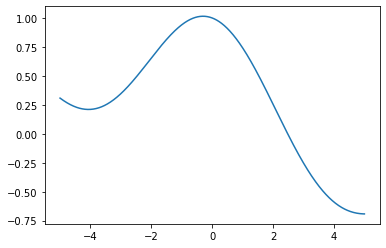

In [55]:
x = np.linspace(-5,5,256*3)

def func_y(x):
    return np.sin(x)/x - x/10
print("Func_y:", func_y(x)) 
y = func_y(x)
#данные два списка надо объединить в один вида data = [(x_0,y_0), (x_1, y_1),..] <- реальные данные 
plt.plot(x, y)
plt.show
x_train, y_train = x, y

In [56]:
# print(x_train)
# print(y_train)

In [57]:
train = np.array([x_train[0], y_train[0]])
for i in range(1, len(x_train)):
  # print(x_train[i])
  new_arr = [x_train[i], y_train[i]]
  train = np.vstack([train, new_arr])
  # print(train)
# train_data = np.array([[x_train[i], y_train[i]] for i in range(x_train.shape[0])])
train[:5]

array([[-5.        ,  0.30821515],
       [-4.98696219,  0.30568473],
       [-4.97392438,  0.30318078],
       [-4.96088657,  0.30070362],
       [-4.94784876,  0.29825357]])

In [58]:
n_epochs = 250
batch_size = 256
lr = 0.0002

b1 = 0.5
b2 = 0.999


# DATA_SIZE = batch_size * 300

# MIN_X = -5 #-1000
# MAX_X = 5 # 1000

hidden_dim = 20

# noise random uniform min and max values
noise_min = -1.0
noise_max = 1.0





In [59]:
# n_epochs = 200
# batch_size = 64
# lr = 0.0002

# b1 = 0.5
# b2 = 0.999

# latent_dim = 100

# n_classes = 10
# img_size = 28
# channels = 1

# sample_interval = 25

# img_shape = (channels, img_size, img_size)

In [60]:
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=12)

In [61]:
SAMPLES_COUNT_IN_DATASET =trainloader.dataset.data.shape[0]
SAMPLES_COUNT_IN_DATASET

768

In [62]:
BATCHES_IN_DATA_COUNT = math.ceil(SAMPLES_COUNT_IN_DATASET / batch_size)
BATCHES_IN_DATA_COUNT

3

In [63]:
# import os
# import numpy as np
# import math

# from torch.utils.data import DataLoader
# import torchvision.transforms as transforms
# from torchvision import datasets
# from torch.autograd import Variable

# import torch.nn as nn
# import torch

# ########### Вывод изображений и сохранение ################################
# import matplotlib.pyplot as plt

# from IPython import display
# from torchvision.utils import save_image, make_grid



In [64]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat, normalize=True): #activation='relu
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(20, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 2)
        )

    def forward(self, z):
        img = self.model(z)
        return img


In [65]:
gen_model = Generator().double().to(device)

In [66]:
# class CustomLinearLayer(nn.Module):
#     def __init__(self, size_in, size_out):
#         super().__init__()
#         self.size_in, self.size_out = size_in, size_out
        
#         weights = torch.Tensor(size_out, size_in)
#         self.weights = nn.Parameter(weights) 

#         bias = torch.Tensor(size_out)
#         self.bias = nn.Parameter(bias)

#         nn.init.uniform_(self.weights, -0.05, 0.05) 
#         nn.init.uniform_(self.bias, -0.05, 0.05)  

#     def forward(self, x):
#         w_times_x = torch.mm(x, self.weights.t())
#         return torch.add(w_times_x, self.bias)  

In [67]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) 

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.25, 0.25) 
        nn.init.uniform_(self.bias, -0.25, 0.25)  

    def forward(self, x):
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

In [68]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(2, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, coords):
        coords_flat = coords.view(coords.size(0), -1)
        validity = self.model(coords_flat)

        return validity

In [69]:
# class Discriminator(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.model = nn.Sequential(
#             CustomLinearLayer(2, 512),
#             nn.LeakyReLU(0.2, inplace=True),
#             # CustomLinearLayer(1024, 512),
#             # nn.LeakyReLU(0.2, inplace=True),
#             CustomLinearLayer(512, 256),
#             nn.LeakyReLU(0.2, inplace=True),
#             CustomLinearLayer(256, 1),
#             nn.Sigmoid(),
#         )
  

#     def forward(self, coords):
#         coords_flat = coords.view(coords.size(0), -1)
#         validity = self.model(coords_flat)

#         return validity

In [70]:
discriminator_model = Discriminator().to(device)

In [71]:
optimizer_G = torch.optim.Adam(gen_model.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator_model.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

[Epoch 500/500] [D loss: 0.680081] [G loss: 0.712041]


<Figure size 432x288 with 0 Axes>

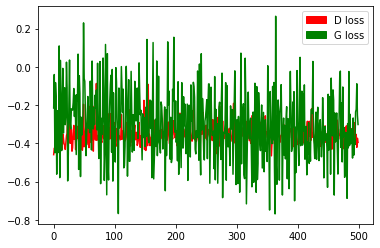

CPU times: user 1min 57s, sys: 3min 11s, total: 5min 8s
Wall time: 7min 20s


In [74]:
%%time

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

d_loss_history = []
g_loss_history = []

for epoch in range(n_epochs):
    
    generator_epoch_loss = 0.0
    discriminator_epoch_loss = 0.0
    
    for i, data in enumerate(trainloader):
#         print(i, data)

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)
        
        real_coords = Variable(data.type(torch.FloatTensor)).to(device)

######################  Тренировка генератора    ##########################
        
        optimizer_G.zero_grad()
    
        #генерация шума
        z = Variable(torch.from_numpy(np.random.uniform(noise_min, noise_max, (batch_size, hidden_dim)).astype(np.float64)).double()).to(device)

        gen_coords = gen_model(z)

        validity = discriminator_model(gen_coords.float())
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()
        
        generator_epoch_loss += g_loss.item()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator_model(real_coords.float())
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator_model(gen_coords.detach().float())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        discriminator_epoch_loss += d_loss.item()

######## Отображение процесса обучения и вывод функций потерь ############
        if (i+1) % BATCHES_IN_DATA_COUNT == 0:
            plt.clf()
            
            display.clear_output(wait=False)
            print("[Epoch %d/%d] [D loss: %f] [G loss: %f]"% (epoch+1, n_epochs, discriminator_epoch_loss / BATCHES_IN_DATA_COUNT, generator_epoch_loss / BATCHES_IN_DATA_COUNT)) 

            
            display.display(plt.gcf())
            
            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])
            plt.show()
# plt.show()


In [75]:
gen_model.eval()

xx = Variable(torch.from_numpy(np.random.uniform(noise_min, noise_max, (batch_size, hidden_dim)).astype(np.float64)).double()).to(device)

with torch.no_grad():
    test_pred = gen_model(xx)

gen_model.train()

test_pred = test_pred.cpu().detach().numpy()

In [76]:
count = 0
error = 0.0
for i in range(len(test_pred)):
    xxx = test_pred[i][0]
    y_pred = test_pred[i][1]
    y_real = func_y(xxx)
    # print("X: %.10f;\t" % xxx, "y_pred: %.10f;\t\t" % y_pred, "y_real: %.10f" % y_real)
    
    count +=1
    error += abs(y_real - y_pred)

print("\nTotal mean error: %.10f" % (error/count))


Total mean error: 0.0440474220


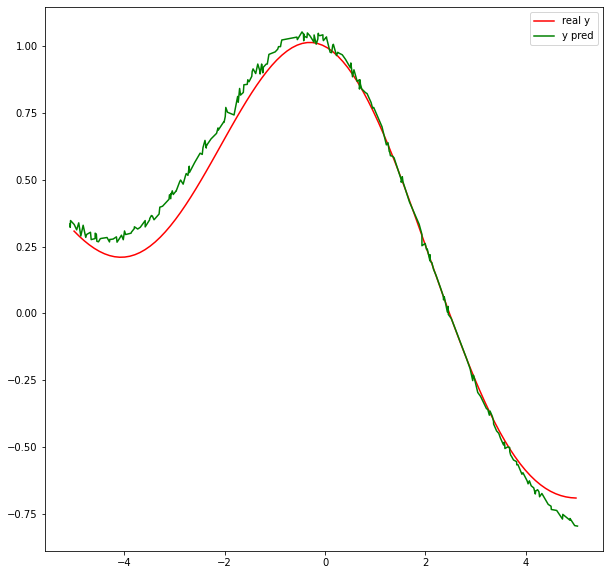

In [77]:
figure(num=None, figsize=(10, 10))

real_x = np.linspace(-5, 5, 100)
plt.plot(real_x, func_y(real_x), label='real y', color = 'red')

p = test_pred[:,0].argsort()
plt.plot(test_pred[:,0][p], test_pred[:, 1][p], label='y pred', color = 'green')


plt.legend()
plt.show()